In [8]:
# =============================================================================
# Cell 1: Import Libraries and Check CUDA Availability
# =============================================================================
import os
import re
import gc
import torch
import numpy as np
import tifffile
import pandas as pd
from nd2reader import ND2Reader
from tqdm import tqdm
from cellpose import models
from tqdm import tqdm

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")
else:
    print("No GPU detected or CUDA is not available.")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4090


In [2]:
# =============================================================================
# Function: Convert ND2 to TIFF for a Given Channel
# =============================================================================
def convert_nd2_to_tiff_channel(nd2_path, tiff_output_dir, channel_name):
    """
    Converts an ND2 file to TIFF files by performing a maximum intensity projection
    over the z-axis for the specified channel.
    """
    try:
        with ND2Reader(nd2_path) as img:
            print(f"\nProcessing ND2 file: {os.path.basename(nd2_path)}")
            print("Detected Axes:", img.axes)
            print("Detected Shape:", img.shape)
            channels = img.metadata.get('channels')
            if channels is None:
                raise ValueError("No channel information found in ND2 metadata.")
            print("Channels in file:", channels)
            if channel_name in channels:
                channel_index = channels.index(channel_name)
                print(f"Using channel '{channel_name}' at index {channel_index}.")
            else:
                print(f"Channel '{channel_name}' not found in {nd2_path}. Skipping conversion for this channel.")
                return
            img.default_coords['c'] = channel_index

            # Set up iteration: if a time axis exists, iterate over it and bundle z,y,x.
            if 't' in img.axes and img.sizes.get('t', 1) > 1:
                img.iter_axes = 't'
                img.bundle_axes = 'zyx'
            else:
                img.iter_axes = ''
                img.bundle_axes = 'zyx'
                
            # For each time frame (or single image), perform a max projection along z.
            for idx, frame in enumerate(img):
                max_proj = np.max(frame, axis=0)
                base_name = os.path.splitext(os.path.basename(nd2_path))[0]
                if 't' in img.axes and img.sizes.get('t', 1) > 1:
                    tiff_filename = f"{base_name}_t{idx}.tiff"
                else:
                    tiff_filename = f"{base_name}.tiff"
                tiff_path = os.path.join(tiff_output_dir, tiff_filename)
                tifffile.imwrite(tiff_path, max_proj)
                print(f"Saved TIFF: {tiff_path}")
    except Exception as e:
        print(f"Error converting {nd2_path} for channel {channel_name} to TIFF: {e}")

# =============================================================================
# Function: Generate Cell Mask Using Cellpose
# =============================================================================
def generate_cellmask(tiff_path, mask_path, model):
    """
    Generates a cell mask from the given TIFF image using Cellpose and saves the mask.
    """
    try:
        img = tifffile.imread(tiff_path)
        # If the image is 3D (a stack), average over the first axis to obtain a 2D image.
        if img.ndim == 3:
            img = img.mean(axis=0)
        elif img.ndim > 3:
            raise ValueError(f"Unexpected number of dimensions ({img.ndim}) in image: {tiff_path}")

        img_min, img_max = np.min(img), np.max(img)
        dynamic_range = img_max - img_min
        if dynamic_range == 0:
            print(f"Warning: Image {tiff_path} has zero dynamic range. Skipping mask generation.")
            return
        img = img.astype(np.float32)
        img = (img - img_min) / dynamic_range

        if not np.isfinite(img).all():
            print(f"Warning: Image {tiff_path} contains non-finite values after normalization. Skipping.")
            return

        # Run Cellpose (adjust parameters such as diameter if needed)
        masks, flows, styles, diams = model.eval(
            img,
            diameter=None,
            flow_threshold=0.4,
            cellprob_threshold=0.0,
            channels=[0, 0]
        )
        tifffile.imwrite(mask_path, masks.astype(np.uint16))
        print(f"Saved cell mask: {mask_path}")
    except Exception as e:
        print(f"Error generating mask for {tiff_path}: {e}")
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# =============================================================================
# Function: Calculate Cell-Level Intensities
# =============================================================================
def calculate_intensities(tiff_files, tiff_dirs, mask_dir, output_csv):
    """
    For each TIFF file, calculates the average intensity per cell (using the generated mask)
    for both GFP and DSred channels and saves the data to a CSV file.
    """
    data = []
    for tiff_file in tqdm(tiff_files, desc="Calculating Intensities"):
        gfp_path = os.path.join(tiff_dirs["GFP"], tiff_file)
        dsred_path = os.path.join(tiff_dirs["DSred"], tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if not os.path.exists(gfp_path):
            print(f"GFP image {gfp_path} not found. Skipping.")
            continue
        if not os.path.exists(dsred_path):
            print(f"DSred image {dsred_path} not found. Skipping.")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask image {mask_path} not found. Skipping.")
            continue
        
        gfp_img = tifffile.imread(gfp_path)
        dsred_img = tifffile.imread(dsred_path)
        mask_img = tifffile.imread(mask_path)
        
        mask_indices = np.unique(mask_img)
        mask_indices = mask_indices[mask_indices != 0]  # exclude background
        
        for idx in mask_indices:
            cell_mask = (mask_img == idx)
            avg_gfp = np.mean(gfp_img[cell_mask])
            avg_dsred = np.mean(dsred_img[cell_mask])
            data.append({
                "File Name": tiff_file,
                "Mask Index": idx,
                "Average GFP Intensity": avg_gfp,
                "Average DSred Intensity": avg_dsred
            })
    
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Cell-level intensity data saved to {output_csv}")

# =============================================================================
# Helper Function: Extract Group, Sample, and Repeat Information
# =============================================================================
def extract_info_from_filename(filename):
    """
    Extracts group (Act/Rep), sample (e.g., 01), and repeat (e.g., 002) from the TIFF filename.
    It first removes any time suffix (e.g., _t0) if present.
    """
    base = re.sub(r'_t\d+', '', os.path.splitext(filename)[0])
    pattern = re.compile(r'^(Act|Rep)_(\d{2})_(\d{3})', re.IGNORECASE)
    m = pattern.search(base)
    if m:
        return m.group(1), m.group(2), m.group(3)
    else:
        return 'Unknown', 'Unknown', 'Unknown'

# code to analysis

In [ ]:
# =============================================================================
# Runnable Step 1: ND2-to-TIFF Conversion
# =============================================================================
def run_conversion(nd2_dir, dsred_tiff_dir, gfp_tiff_dir):
    nd2_files = [f for f in os.listdir(nd2_dir) if f.lower().endswith('.nd2')]
    if not nd2_files:
        print("No ND2 files found in", nd2_dir)
        return
    print(f"Found {len(nd2_files)} ND2 file(s) for conversion.")
    for nd2_file in nd2_files:
        nd2_path = os.path.join(nd2_dir, nd2_file)
        print(f"\n--- Processing: {nd2_file} ---")
        convert_nd2_to_tiff_channel(nd2_path, dsred_tiff_dir, '60x DSRED')
        convert_nd2_to_tiff_channel(nd2_path, gfp_tiff_dir, '60x GFP')

# Set up directories
nd2_dir = r"A:\_Ongoing\20250128_ActRep_version2_24well"
output_dir = os.path.join(nd2_dir, "Output")
dsred_tiff_dir = os.path.join(output_dir, "60x_DSRED_TIFF")
gfp_tiff_dir   = os.path.join(output_dir, "60x_GFP_TIFF")
mask_dir       = os.path.join(output_dir, "mask")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(dsred_tiff_dir, exist_ok=True)
os.makedirs(gfp_tiff_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Run conversion
run_conversion(nd2_dir, dsred_tiff_dir, gfp_tiff_dir)



In [ ]:
# =============================================================================
# Runnable Step 2: Cell Mask Generation
# =============================================================================
def run_mask_generation(dsred_tiff_dir, mask_dir, model):
    dsred_tiff_files = [f for f in os.listdir(dsred_tiff_dir)
                        if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    if not dsred_tiff_files:
        print("No DSred TIFF files found in", dsred_tiff_dir)
        return
    print(f"Generating cell masks for {len(dsred_tiff_files)} DSred TIFF file(s)...")
    for tiff_file in tqdm(dsred_tiff_files, desc="Generating Masks"):
        tiff_path = os.path.join(dsred_tiff_dir, tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        generate_cellmask(tiff_path, mask_path, model)
    print("Cell mask generation completed.")

print("\n=== Cell Mask Generation ===")
try:
    model = models.Cellpose(gpu=torch.cuda.is_available(), model_type="cyto3")
    print("Cellpose model initialized.")
except Exception as e:
    print("Error initializing Cellpose model:", e)
    print("Falling back to CPU mode with cyto2.")
    model = models.Cellpose(gpu=False, model_type="cyto2")
run_mask_generation(dsred_tiff_dir, mask_dir, model)


In [10]:
# =============================================================================
# Runnable Step 3: Intensity Calculation and Excel Output
# =============================================================================
def extract_info_from_filename(filename):
    """
    Extracts group (Act/Rep), sample, and repeat from a filename.
    
    For example, given "Act_01_001.tiff", it returns ("Act", "01", "001").
    If the pattern is not found, returns ('Unknown', 'Unknown', 'Unknown').
    """
    # Remove any time suffix (e.g., _t0) and file extension
    base = re.sub(r'_t\d+', '', os.path.splitext(filename)[0])
    pattern = re.compile(r'^(Act|Rep)_(\d{2})_(\d{3})', re.IGNORECASE)
    m = pattern.search(base)
    if m:
        return m.group(1), m.group(2), m.group(3)
    else:
        return 'Unknown', 'Unknown', 'Unknown'

def create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel):
    """
    Processes DSred TIFF files (and their corresponding GFP TIFF and mask files)
    to calculate cell-level intensities. For each cell (as determined by the mask),
    the average intensities in the GFP and DSred channels are computed.
    
    It then extracts Group, Sample, and Repeat information from the original file name
    (e.g., "Act_01_001.tiff") and writes an Excel file with the following columns:
      - Group, Sample, Repeat, Mask Index, GFP_Mean, DSred_Mean
      
    Parameters:
      dsred_tiff_dir: Directory containing DSred TIFF files.
      gfp_tiff_dir: Directory containing GFP TIFF files (with matching filenames).
      mask_dir: Directory containing mask files (named as the TIFF base with '_mask.tiff').
      output_excel: Path for the output Excel file.
    """
    # List DSred TIFF files (skip any mask files)
    dsred_files = [f for f in os.listdir(dsred_tiff_dir)
                   if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    
    if not dsred_files:
        print("No DSred TIFF files found in", dsred_tiff_dir)
        return
    
    data = []
    
    # Loop over each DSred TIFF file
    for tiff_file in tqdm(dsred_files, desc="Processing TIFF files"):
        # Construct full paths for DSred, GFP, and mask files.
        dsred_path = os.path.join(dsred_tiff_dir, tiff_file)
        gfp_path = os.path.join(gfp_tiff_dir, tiff_file)
        # Assume mask file is named like "<base>_mask.tiff"
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        # Verify that the corresponding GFP and mask files exist.
        if not os.path.exists(gfp_path):
            print(f"GFP file not found for {tiff_file}, skipping.")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask file not found for {tiff_file}, skipping.")
            continue
        
        # Read the images
        try:
            dsred_img = tifffile.imread(dsred_path)
            gfp_img = tifffile.imread(gfp_path)
            mask_img = tifffile.imread(mask_path)
        except Exception as e:
            print(f"Error reading files for {tiff_file}: {e}")
            continue
        
        # Identify unique cell labels (ignore background, assumed to be 0)
        cell_indices = np.unique(mask_img)
        cell_indices = cell_indices[cell_indices != 0]
        
        # Calculate average intensity for each cell
        for cell in cell_indices:
            cell_mask = (mask_img == cell)
            avg_gfp = np.mean(gfp_img[cell_mask])
            avg_dsred = np.mean(dsred_img[cell_mask])
            record = {
                "File Name": tiff_file,
                "Mask Index": cell,
                "Average GFP Intensity": avg_gfp,
                "Average DSred Intensity": avg_dsred
            }
            data.append(record)
    
    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    
    # Extract Group, Sample, and Repeat from the "File Name" column
    df[['Group', 'Sample', 'Repeat']] = df['File Name'].apply(lambda x: pd.Series(extract_info_from_filename(x)))
    
    # Drop the original "File Name" column as it is no longer needed
    df = df.drop(columns=["File Name"])
    
    # Rename intensity columns for clarity
    df = df.rename(columns={
        "Average GFP Intensity": "GFP_Mean",
        "Average DSred Intensity": "DSred_Mean"
    })
    
    # Rearrange columns in the desired order
    df = df[['Group', 'Sample', 'Repeat', 'Mask Index', 'GFP_Mean', 'DSred_Mean']]
    
    # Write the DataFrame to an Excel file
    df.to_excel(output_excel, index=False)
    print("Excel summary saved to:", output_excel)

# ----- Usage -----
# Adjust these paths as needed.
dsred_tiff_dir = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\60x_DSRED_TIFF"
gfp_tiff_dir   = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\60x_GFP_TIFF"
mask_dir       = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\mask"
output_excel   = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\summary.xlsx"

create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel)


Processing TIFF files: 100%|██████████| 252/252 [00:02<00:00, 120.91it/s]


Excel summary saved to: A:\_Ongoing\20250128_ActRep_version2_24well\Output\summary.xlsx


# cellpose checing visulize

In [11]:
import random
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_random_samples(tiff_output_dir, cellmask_output_dir, num_samples=5, seed=None):
    """
    Randomly selects and visualizes TIFF images with their corresponding Cellpose masks.
    
    Parameters:
    - tiff_output_dir: Directory containing the max projected TIFF images.
    - cellmask_output_dir: Directory containing the Cellpose mask TIFFs.
    - num_samples: Number of random samples to visualize.
    - seed: (Optional) Seed for reproducibility.
    """
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Get list of TIFF files
    tiff_files = [f for f in os.listdir(tiff_output_dir) if f.lower().endswith(('.tiff', '.tif'))]
    
    if not tiff_files:
        print(f"No TIFF files found in {tiff_output_dir}.")
        return
    
    # Adjust num_samples if there are fewer files than requested
    num_samples = min(num_samples, len(tiff_files))
    
    # Randomly select samples
    samples = random.sample(tiff_files, num_samples)
    
    for tiff_file in samples:
        tiff_path = os.path.join(tiff_output_dir, tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(cellmask_output_dir, mask_filename)
        
        # Check if mask file exists
        if not os.path.exists(mask_path):
            print(f"Mask file {mask_filename} does not exist. Skipping.")
            continue
        
        try:
            img = tifffile.imread(tiff_path)
            mask = tifffile.imread(mask_path)
            
            # If image has multiple channels, convert to grayscale by averaging
            if img.ndim == 3:
                img_display = img.mean(axis=0)
            else:
                img_display = img
            
            # Normalize image for display
            img_display = img_display.astype(np.float32)
            img_display -= img_display.min()
            if img_display.max() != 0:
                img_display /= img_display.max()
            
            plt.figure(figsize=(12, 6))
            
            # Display Original Image
            plt.subplot(1, 2, 1)
            plt.imshow(img_display, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            # Display Mask Overlay
            plt.subplot(1, 2, 2)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
            plt.title('Cellpose Mask Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing {tiff_file}: {e}")


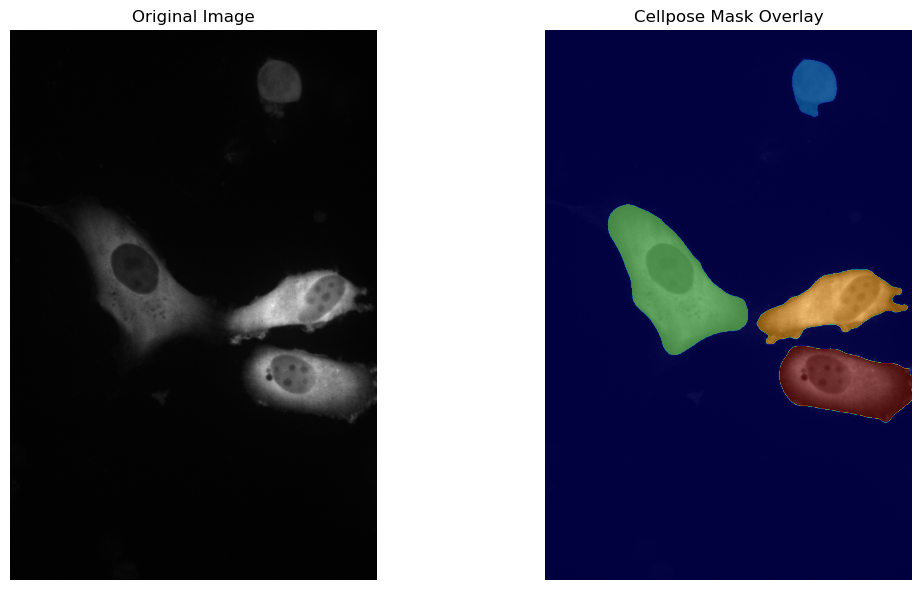

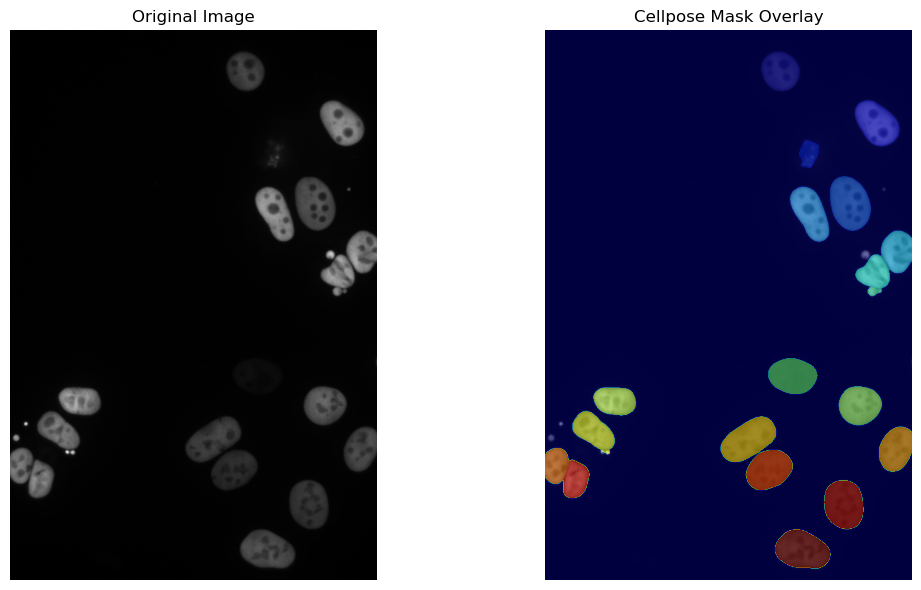

In [12]:
# Define the directories (use the same as in your main code)
nd2_dir = r"A:\_Ongoing\20250128_ActRep_version2_24well"
tiff_output_dir = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\60x_DSRED_TIFF"
cellmask_output_dir = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\mask"

# Visualize random samples
visualize_random_samples(tiff_output_dir, cellmask_output_dir, num_samples=2, seed=4)


# analyze the ratio of expression

In [21]:
import os
import numpy as np
import pandas as pd

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input summary file (previous step's output) containing:
# Group, Sample, Repeat, Mask Index, GFP_Mean, DSred_Mean
input_excel = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\summary.xlsx"

# Output Excel file with reporter expression data
output_excel = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\reporter_expression.xlsx"

# Define which sample is the control (as a two-digit string).
# For example, if sample "20" is the control, set:
control_sample = "20"

# Define a mapping for sample codes to descriptive names.
sample_mapping = {
    "01": "Tile 1",
    "02": "Tile 2",
    "03": "Tile 3",
    "04": "Tile 4",
    "05": "Tile 5",
    "06": "Tile 6",
    "07": "Tile 7",
    "08": "Tile 8",
    "09": "Tile 9",
    "10": "Tile 10",
    "11": "Tile 11",
    "12": "Tile 12",
    "13": "Tile 13",
    "14": "Tile 14",
    "15": "LAP*IDR",
    "16": "LAPIDR",
    "17": "LIPIDR",
    "18": "FL",
    "19": "optLAP*IDR",
    "20": "Halo_NLS",
    "21": "AR_RUNX2",
    "22": "Tile1woNLS",
    "23": "RUNX2CTD",
    "24": "VP16"
}

# -----------------------------
# READ INPUT DATA
# -----------------------------
# The input Excel file is expected to have columns:
# Group, Sample, Repeat, Mask Index, GFP_Mean, DSred_Mean
df = pd.read_excel(input_excel)

# Ensure the Sample column is stored as a two-digit string.
df['Sample'] = df['Sample'].apply(lambda x: str(x).zfill(2))

# -----------------------------
# COMPUTE REPORTER EXPRESSION (AS RATIO)
# -----------------------------
def compute_expression_for_group(group_df, control_sample):
    """
    For a given group (e.g. 'Act' or 'Rep'), compute the control mean intensities
    (for GFP and DSred) based on the rows where Sample == control_sample, and then
    calculate the reporter expression as:
    
         reporter expression = cell intensity / control mean intensity
         
    If control data are missing, the reporter expression is set to NaN.
    """
    # Filter rows for the control sample.
    control_data = group_df[group_df['Sample'] == control_sample]
    if control_data.empty:
        print(f"Warning: No control data found in group {group_df['Group'].iloc[0]}.")
        control_mean_GFP = np.nan
        control_mean_DSred = np.nan
    else:
        control_mean_GFP = control_data["GFP_Mean"].mean()
        control_mean_DSred = control_data["DSred_Mean"].mean()
    
    # Compute reporter expression as the ratio (do not take log).
    group_df["GFP_expr"] = group_df["GFP_Mean"].apply(lambda x: x/control_mean_GFP if control_mean_GFP and control_mean_GFP > 0 else np.nan)
    group_df["DSred_expr"] = group_df["DSred_Mean"].apply(lambda x: x/control_mean_DSred if control_mean_DSred and control_mean_DSred > 0 else np.nan)
    return group_df

# Process each group (e.g. 'Act' and 'Rep') separately.
groups = df['Group'].unique()
df_list = []
for grp in groups:
    grp_df = df[df['Group'] == grp].copy()
    grp_df = compute_expression_for_group(grp_df, control_sample)
    df_list.append(grp_df)
df_new = pd.concat(df_list, ignore_index=True)

# -----------------------------
# MAP SAMPLE CODES TO DESCRIPTIVE NAMES
# -----------------------------
df_new["Sample_name"] = df_new["Sample"].map(sample_mapping)

# -----------------------------
# REARRANGE COLUMNS & SAVE
# -----------------------------
# Final DataFrame columns:
# Group, Sample, Sample_name, Repeat, Mask Index, GFP_Mean, DSred_Mean, GFP_expr, DSred_expr
cols_order = ["Group", "Sample", "Sample_name", "Repeat", "Mask Index", "GFP_Mean", "DSred_Mean", "GFP_expr", "DSred_expr"]
df_new = df_new[cols_order]

# Write the DataFrame to the output Excel file.
df_new.to_excel(output_excel, index=False)
print("Reporter expression Excel file saved to:", output_excel)



Reporter expression Excel file saved to: A:\_Ongoing\20250128_ActRep_version2_24well\Output\reporter_expression.xlsx


# Plot

C:\Users\NongyunWang\AppData\Local\Temp\ipykernel_16312\3430438652.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(sorted_box_data, vert=False, patch_artist=True, labels=sorted_sample_names)


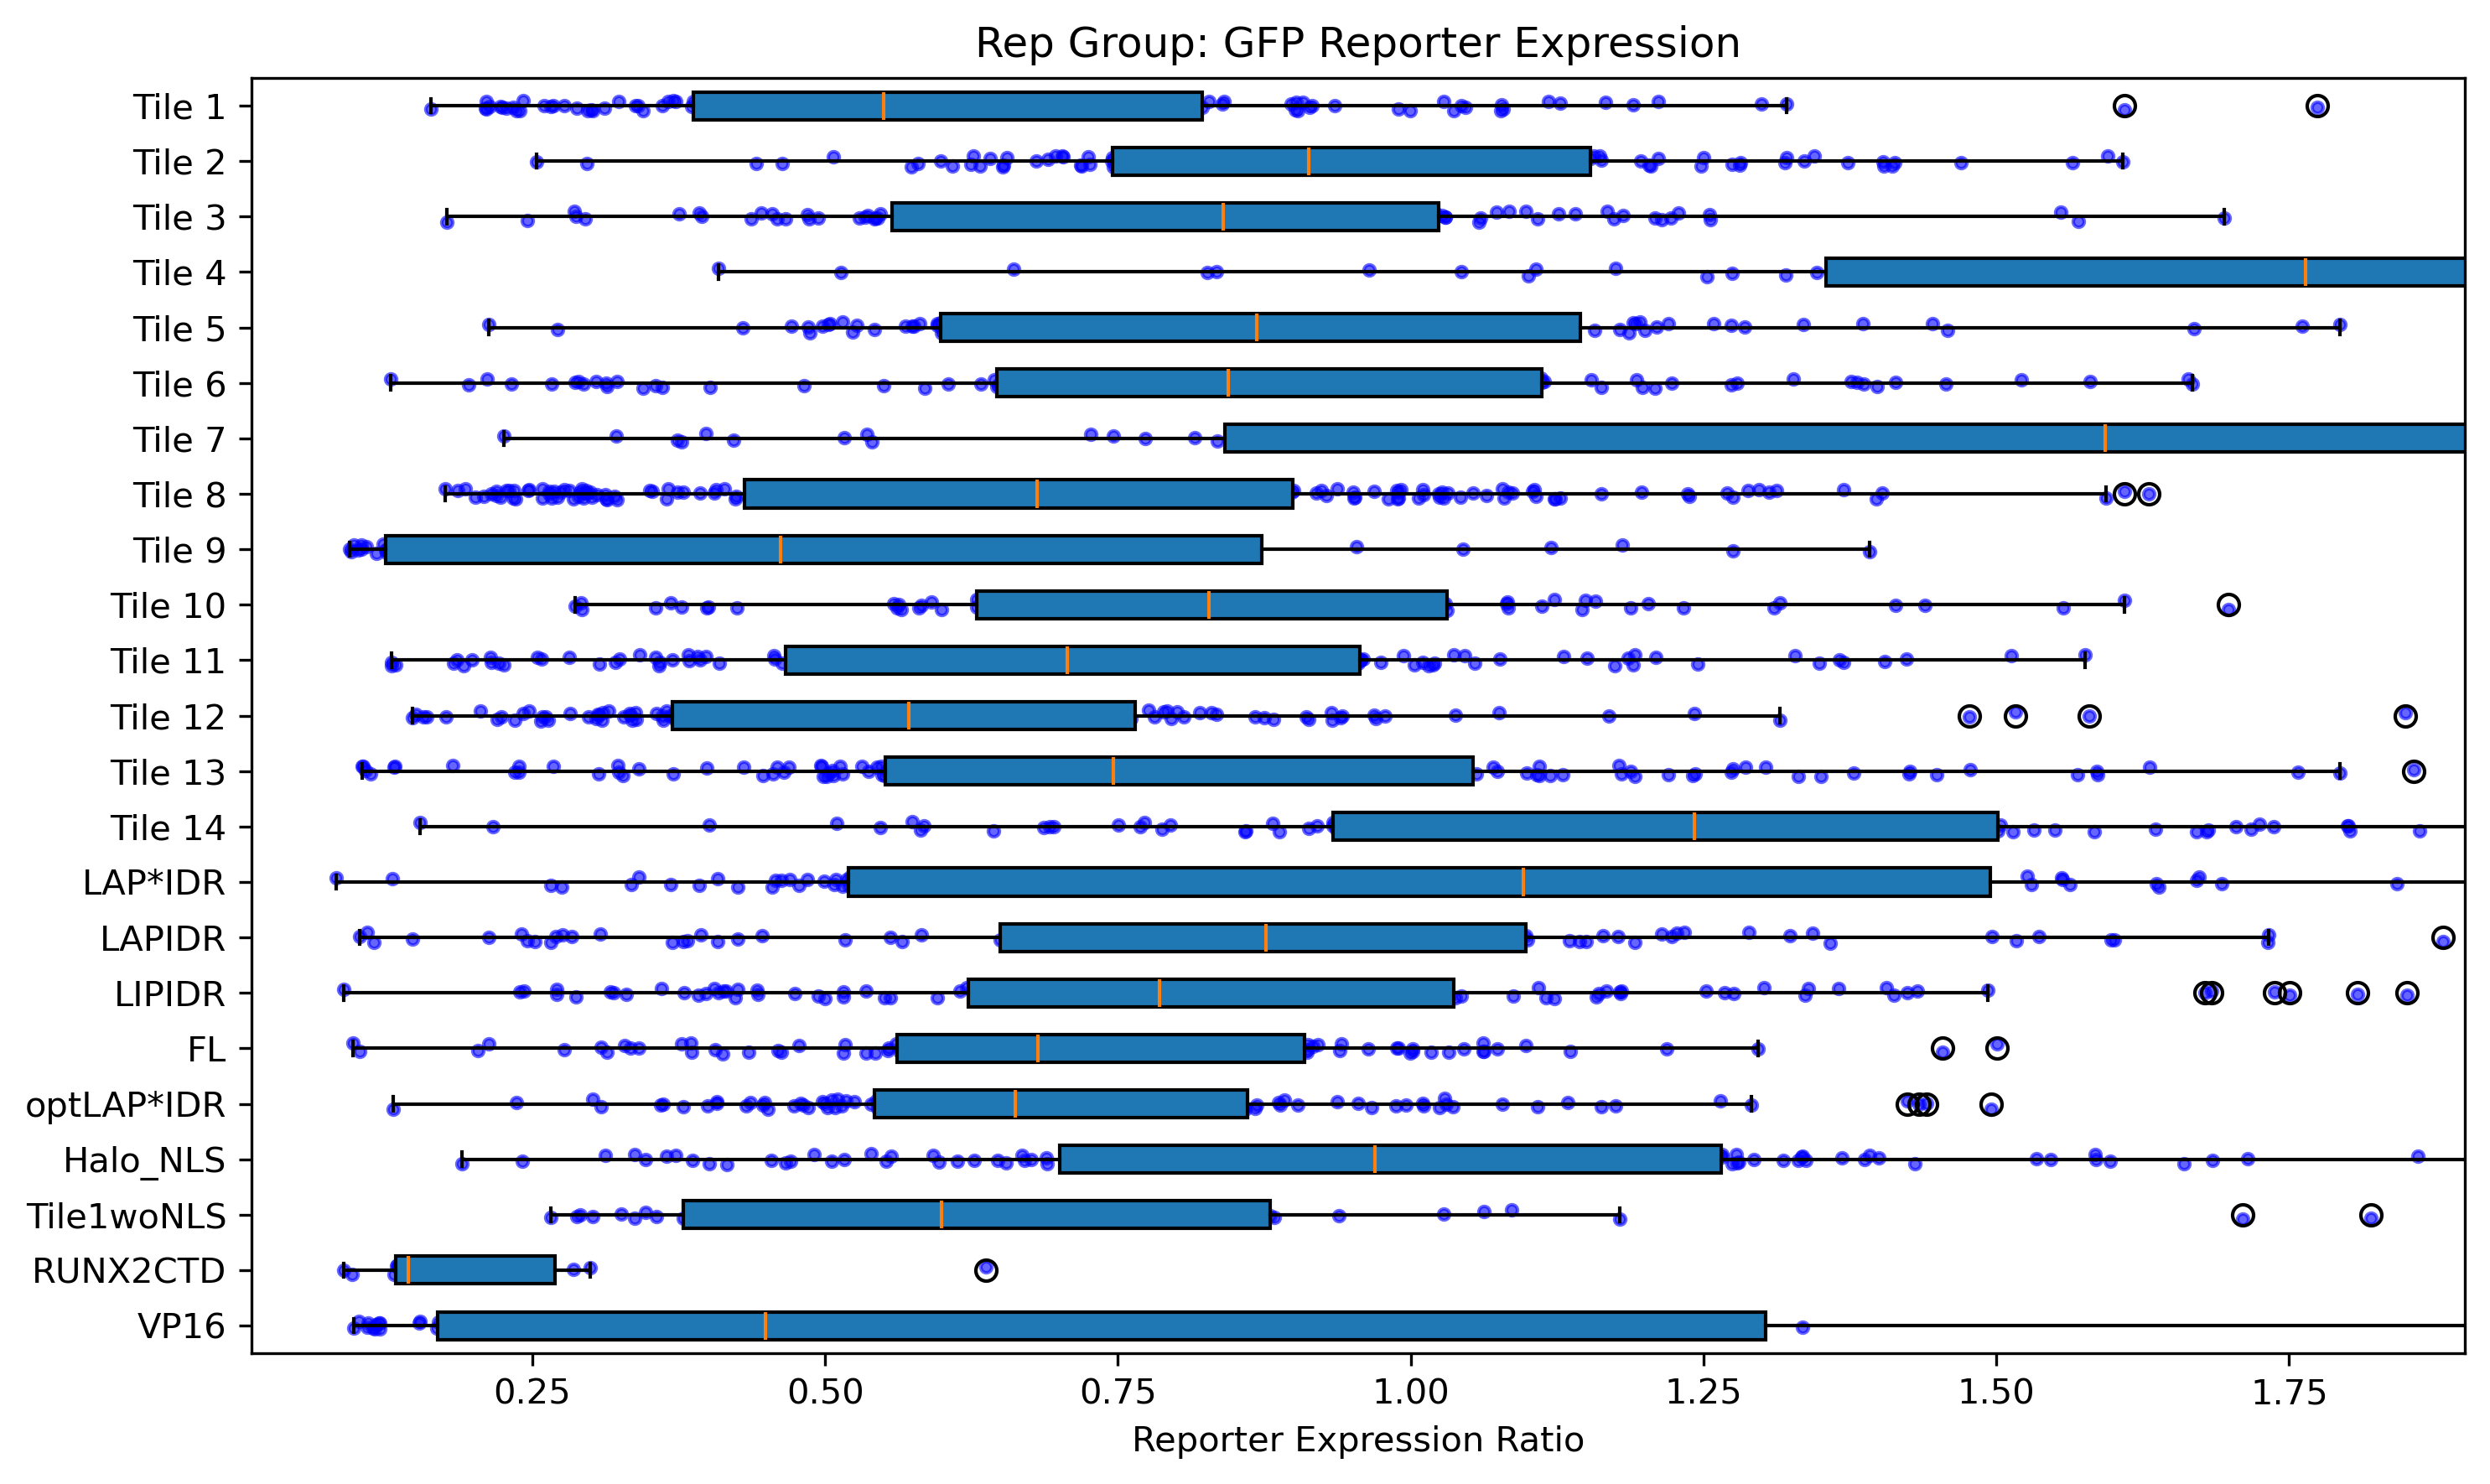

Plot saved to: A:\_Ongoing\20250128_ActRep_version2_24well\Output\Rep_GFP_horizontal_boxplot.png


'\n# 4. Rep Group, DSred reporter expression.\ncreate_horizontal_boxplot_no_log(\n    df=df_reporter,\n    group=\'Rep\',\n    channel=\'DSred_expr\',\n    save_path=os.path.join(output_folder, "Rep_DSred_horizontal_boxplot.png"),\n    xlim=x_axis_limits\n)\n'

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_horizontal_boxplot_no_log(df, group, channel, save_path, xlim=None):
    """
    Creates a horizontal box plot for reporter expression data on the original ratio scale,
    grouped by sample for a specified group and channel.
    
    Parameters:
      df        : DataFrame containing reporter expression data. Expected columns include:
                  'Group', 'Sample', 'Sample_name', and a reporter expression column 
                  (e.g., 'GFP_expr' or 'DSred_expr') that contains the ratio values.
      group     : String, either 'Act' or 'Rep'.
      channel   : String, either 'GFP_expr' or 'DSred_expr'.
      save_path : Full file path (including filename) where the plot will be saved.
      xlim      : Optional tuple (xmin, xmax) to set fixed x-axis limits (e.g. (0.5, 100)). 
                  If None, auto-scaling is used.
    
    The y-axis will display the sample names (descriptive names from the 'Sample_name' column)
    in reversed order (i.e. the lowest sample code at the top).
    """
    # Filter the DataFrame for the desired group and ensure channel data is not missing.
    sub_df = df[(df['Group'] == group) & (df[channel].notnull())].copy()
    
    # Group data by Sample.
    grouped = sub_df.groupby('Sample')
    
    sample_order = []   # List to hold sample codes as integers (for sorting)
    box_data = []       # List of arrays; each array contains the raw reporter ratios for a sample.
    sample_names = {}   # Mapping from sample code (int) to descriptive sample name.
    
    for sample, group_data in grouped:
        values = group_data[channel].values
        if len(values) == 0:
            continue
        # No log transformation: use the raw ratio values.
        box_data.append(values)
        sample_order.append(int(sample))
        # Assume all rows in a sample have the same descriptive sample name.
        sample_names[int(sample)] = group_data['Sample_name'].iloc[0]
    
    # Sort samples in ascending order.
    sorted_indices = np.argsort(sample_order)
    sorted_samples = [sample_order[i] for i in sorted_indices]
    sorted_box_data = [box_data[i] for i in sorted_indices]
    sorted_sample_names = [sample_names[s] for s in sorted_samples]
    
    # Create the horizontal box plot.
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # Draw the box plot horizontally. (The boxes are plotted in the order of the list.)
    bp = ax.boxplot(sorted_box_data, vert=False, patch_artist=True, labels=sorted_sample_names)
    
    # Overlay individual data points with slight vertical jitter.
    for i, values in enumerate(sorted_box_data):
        y_jitter = np.random.uniform(-0.1, 0.1, size=len(values))
        # The default y-position for the i-th box is i+1.
        y_positions = np.full_like(values, i+1) + y_jitter
        ax.scatter(values, y_positions, color='blue', alpha=0.6, s=10)
    
    ax.set_xlabel("Reporter Expression Ratio")
    ylabel = "GFP Reporter Expression" if channel == "GFP_expr" else "DSred Reporter Expression"
    ax.set_title(f"{group} Group: {ylabel}")
    
    # If xlim is provided, set the x-axis limits.
    if xlim is not None:
        ax.set_xlim(xlim)
    
    # Invert the y-axis so that the first sample (e.g., "Tile 1") appears at the top.
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    print("Plot saved to:", save_path)

# ---------------------------
# MAIN: Read Data and Generate Plots
# ---------------------------
# Path to your reporter expression Excel file.
reporter_excel = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output\reporter_expression.xlsx"

# Read the reporter expression data.
df_reporter = pd.read_excel(reporter_excel)

# Ensure that the Sample column is stored as a two-digit string.
df_reporter['Sample'] = df_reporter['Sample'].astype(str).str.zfill(2)

# Define the output folder for plots.
output_folder = r"A:\_Ongoing\20250128_ActRep_version2_24well\Output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Example: Set a fixed x-axis scale from 0.5 to 100.
# To use auto-scaling, set xlim=None.
x_axis_limits = (0.01, 1.9)

# Generate four separate horizontal box plots (using original ratio values):
'''
# 1. Act Group, GFP reporter expression.
create_horizontal_boxplot_no_log(
    df=df_reporter,
    group='Act',
    channel='GFP_expr',
    save_path=os.path.join(output_folder, "Act_GFP_horizontal_boxplot.png"),
    xlim=x_axis_limits
)
'''
'''
# 2. Act Group, DSred reporter expression.
create_horizontal_boxplot_no_log(
    df=df_reporter,
    group='Act',
    channel='DSred_expr',
    save_path=os.path.join(output_folder, "Act_DSred_horizontal_boxplot.png"),
    xlim=x_axis_limits
)
'''
# 3. Rep Group, GFP reporter expression.
create_horizontal_boxplot_no_log(
    df=df_reporter,
    group='Rep',
    channel='GFP_expr',
    save_path=os.path.join(output_folder, "Rep_GFP_horizontal_boxplot.png"),
    xlim=x_axis_limits
)
'''
# 4. Rep Group, DSred reporter expression.
create_horizontal_boxplot_no_log(
    df=df_reporter,
    group='Rep',
    channel='DSred_expr',
    save_path=os.path.join(output_folder, "Rep_DSred_horizontal_boxplot.png"),
    xlim=x_axis_limits
)
'''